# Exploratory Data Analysis (EDA) - Metacritic Critic Reviews

## 1. Introduction

###  1.1 About this document
In order to generate some kind of recommendation I decided to take the critic reviews from Metacritic as a source to determine if a video game is generally well received or not. After running a scraper on Metacritic for over 5 hours, it finally succeeded in gathering all the reviews that were written by the review critics on their website. In this document I write down all the findings that I was able to discover within this dataset.

### 1.2 Goal of this document
The goal of this document is to maximize the analytical insight we can gain of the underlying structure of the data. We look for potential trends, outliers and clusters present within the dataset that can help us to determine the possibilities, opportunities, limitations, and boundaries of the dataset.

## 2. Preperations

### 2.1 Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(style="darkgrid")

### 2.2 Importing the dataset 

In [3]:
df = pd.read_json('../data/game_reviews.json')
df.head(3).append(df.tail(3))

,title,platform,meta_score,review_critic,review_critic_page,review_date,review_source,review_content
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Hot Games,/publication/hot-games?filter=games,"Mar 24, 2016",https://web.archive.org/web/20000302124012/htt...,"A slightly flawed masterpiece, but a masterpie..."
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,GameShark,/publication/gameshark?filter=games,None,https://web.archive.org/web/20030608141504/htt...,"This is, without a doubt, one of the all-time ..."
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Cincinnati Enquirer,/publication/cincinnati-enquirer?filter=games,None,https://web.archive.org/web/20000307234211/htt...,This Zelda adventure will undoubtedly withstan...
426392,Family Party: 30 Great Games Obstacle Arcade,Wii U,10.0,Gamereactor Denmark,/publication/gamereactor-denmark?filter=games,"Dec 12, 2012",http://www.gamereactor.dk/anmeldelser/143661/F...,Do you want sad faces on Xmas? Do you like poi...
426393,Family Party: 30 Great Games Obstacle Arcade,Wii U,10.0,Eurogamer Sweden,/publication/eurogamer-sweden?filter=games,"Dec 12, 2012",http://www.eurogamer.se/articles/2012-12-12-re...,I'm really upset that it isn't illegal to sell...
426394,Family Party: 30 Great Games Obstacle Arcade,Wii U,0.0,Game Revolution,/publication/game-revolution?filter=games,"Jan 22, 2013",http://www.gamerevolution.com/review/family-fu...,"Family Party is terrible. Not only is it bad, ..."


### 2.3 Statistics of the dataset

In [4]:
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (426395, 8)


Roughly 400.000 reviews are present in this dataset. My first intuition would say that this collection can be very valuable for predicting if a product is good or not, but let’s not jump the gun just yet. Another important thing we have to check how many titles we have in this dataset. If we have 400.000 reviews of a single game or only a single review for 400.000 games, we wouldn't get very far now would we...

First let's check how many different games and critics we have in this collection.

In [5]:
df_titles = df.groupby(['title']).size().reset_index(name='count')
print(f"Number of Games: {len(df_titles.index)}")

df_critics = df.groupby(['review_critic']).size().reset_index(name='count')
print(f'Number of Critics: {len(df_critics.index)}')

Number of Games: 11986
Number of Critics: 506


10.000 games with 400.000 reviews gives us an average of 40 reviews for each individual game. That is a great sign. Let's double check that with the actual mean of the dataset.

In [6]:
print(f'Average number of reviews per product: {df_titles["count"].mean()}')

Average number of reviews per product: 35.574420156849655


35.57, which is slightly lower but still a respectable number. If we sort the amount of reviews for each game we can visualize how the distribution changes between the most reviewed game to the least reviewed game.

<AxesSubplot:xlabel='index'>

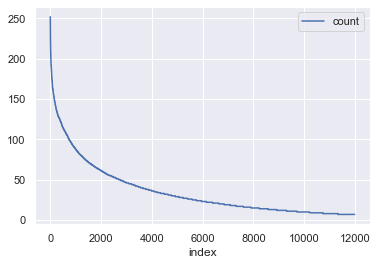

In [7]:
df_titles.sort_values(by='count', inplace=True, ascending=False)
df_titles = df_titles.reset_index(drop=True).reset_index()
df_titles.plot(x='index', y='count')

Roughly 2000 games have over 50 reviews. After that we start see a long stretch for about 6.000 games until we reach the 25 reviews per game mark. I think 25 reviews per game is a great number for estimating how good a product has been rated, but the graph is a bit difficult to read so let’s create a boxplot instead, which hopefully gives us more insight.

<AxesSubplot:xlabel='count'>

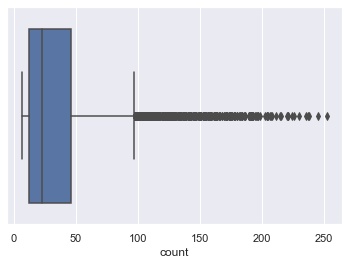

In [8]:
sns.boxplot(x='count', data=df_titles.reset_index())

Here we can clearly see that we have a positive skew between 25 and 50 reviews per game. There are also quite a few outliers that go beyond 100 reviews per game which is nice to see, be it a bit overkill. It also looks like we also have at least a minimum of roughly 5 reviews for all games. Let's quickly confirm this hypothesis.

In [9]:
print(f"Lowest amount of reviews for a game: {df_titles.iloc[-1]['count']}")

Lowest amount of reviews for a game: 7


Seven should be a good starting point for deducing if a product is good or not. Obviously, the more reviews the better. We could increase this threshold if it proves to not be enough to create a good recommendation score but that would also reduce the number of products we could recommend to users.

### 2.4 Checking for null values
Next, we start off with checking for null values. Null values can often tell stories of scenarios you might not have originally considered. Every review has to have been written by a human (critic no less) so one would assume that the data is mostly filled in or if unavailable, to have at least a reason for being empty.

In [10]:
df.isnull().sum()

title                      0
platform                   0
meta_score              3856
review_critic              1
review_critic_page         1
review_date           202048
review_source          57073
review_content            32
dtype: int64

### 2.4.1 Review content
Reviews are not obligated to provide any written text to give out a review as long as it's a thrusted critic. The way Metacritic determines who is a critic and who's not is a bit vague but there is an explanation given on their FAQ page. 

* https://www.metacritic.com/faq#item20. 

They state that they "re-evaluate these people each year and may make additions and/or deletions". Because they have a team dedicated at deciding who is a critic and who's not, I decided to keep these reviews into consideration.

### 2.4.2 Review dates
We also see a lot of reviews that don't have any dates provided on their time of writing. Let's investigate on the dates we do have and see if we can come to some kind of conclusion as to why so many of them are missing and make a good decision on what to do with these reviews.

In [11]:
df['review_date'] = pd.to_datetime(df['review_date'], format='%b %d, %Y')
print(f"Recording started on: {min(df['review_date']).date()}")

Recording started on: 2010-10-20


If we use the WayBack Time Machine, we can see Metacritic has been around for way longer than the first date that was registered in our dataset. Recordings of the website go way back to the year 2001.

https://web.archive.org/web/https://www.metacritic.com/

<AxesSubplot:xlabel='review_date'>

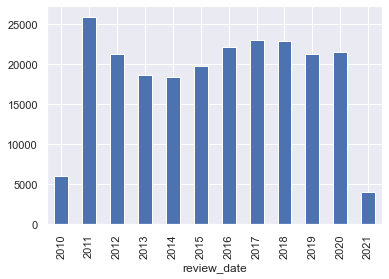

In [12]:
df.groupby(df['review_date'].dt.year.astype('Int64')).size().plot.bar()

When we look at the bar chart, we can see that there is a steady number of reviews with dates provided after the year 2010, which leads me to believe that this feature was implemented around end of the year 2010. If we take a look at some of the recent titles that have been released, we can see that all reviews have a proper date registered.

https://www.metacritic.com/browse/games/score/metascore/year/all/filtered

Because of this, I don't see any reason to discard these reviews as the feature to record datetimes was simply not present at the time. This does not invalidate their score/review in any significant way, especially since games back in 2010 were provided as is without any way of adding additional content or updates at later time compared to the modern day.

### 4.2.3 Review scores
One thing that does strike me as odd is that a lot of reviews don't have a score. My first intuition would be that these are incomplete reviews, however since these reviews are written by critics and it’s their job to write full on reviews, I find it strange that they are so sloppy in their work to not even give an end grade, which leads me to believe that there might be another cause for this. Let's take a deep dive into this.

In [13]:
# Get all rows with a empty meta_score
df_null_score = df[df['meta_score'].isnull()]

# Group these reviews by their critics to see
# if there is a pattern in how they write their reviews
df_null_score_by_critics = df_null_score.groupby(['review_critic'])
df_null_score_by_critics = df_null_score_by_critics.size().reset_index(name='count')

<AxesSubplot:xlabel='review_critic'>

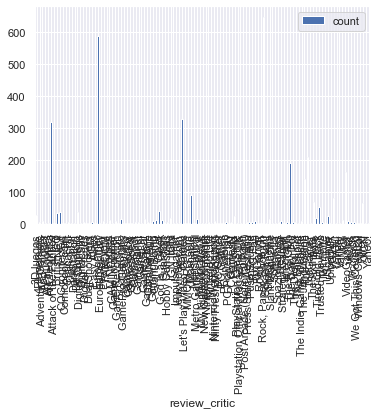

In [14]:
df_null_score_by_critics.plot.bar(x ='review_critic')

Sadly, the number of critics that leave their review unscored are too many to see what is going on, but we can see some huge contributors to this cause so let’s filter down even more by only including critics that left over 10 reviews unscored. Perhaps we can see a pattern here.

<AxesSubplot:xlabel='review_critic'>

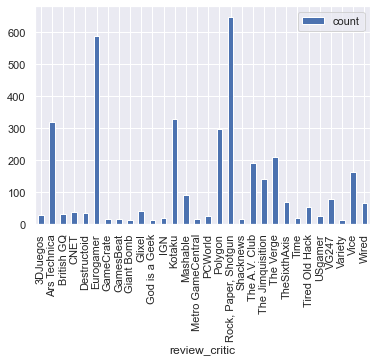

In [15]:
df_null_score_by_critics[df_null_score_by_critics['count'] > 10].plot.bar(x='review_critic')

It appears that Ars Technica, Kotaku, Eurogames, Rock Paper Shotgun are the biggest contributes to these null values, so I decided to visit their page on Metacritic to gather more information. These are links the original sources of these reviews.

* https://www.metacritic.com/publication/ars-technica?filter=games
* https://www.metacritic.com/publication/kotaku?filter=games
* https://www.metacritic.com/publication/eurogamer?filter=games
* https://www.metacritic.com/publication/polygon?filter=games
* https://www.metacritic.com/publication/rock-paper-shotgun?filter=games

When we look at these pages, we can see that none of their (recent) reviews provide any scores, making it look like a deliberate decision by the publisher. What I assume that happened here is that these publications are against the "scoring" system. They only describe the positives and negatives of their experience with the product and leave it up to the reader to decide for themselves if they would like the product or not.

Algorithms perform optimally with numbers, so taking reviews without review scores into account would be difficult. You could make a system to generate a score based on how positive/negative a review is with the use of text interpretation, but that falls out of scope for this project. Luckily not too many reviews are affected by this behavior and most of the products have been properly scored.

Therefore, I decide to exclude all reviews that currently don't have a score (for now). We can use the following command to exclude these figures.

In [16]:
df = df[df['meta_score'].notna()]
df.isnull().sum()

title                      0
platform                   0
meta_score                 0
review_critic              1
review_critic_page         1
review_date           202048
review_source          57063
review_content            32
dtype: int64

### 2.5 Checking for duplicate values
Next up we can double check if we have any duplicate values. We don't want to have duplicate data present in the dataset as it would have an direct influence on the overall score of a game (be it either positive or negative).

In [17]:
print(f'Duplicates: {df.duplicated().sum()}')

Duplicates: 57


Looks like some reviews are posted twice on the website. Because the amount of them is pretty low given the large dataset, I would assume this has something to do with a communication error between the server and the database resulting in a double post. We can quickly resolve these issues using the following command.

In [18]:
df.drop_duplicates(inplace=True)
print(f'Duplicates: {df.duplicated().sum()}')

Duplicates: 0


## 3 Data Analysis

### 3.1 What is the distribution in ratings?
The first think I'd like to see is what the distribution is between the ratings of all products. Just because we have a scale between 0 and 100 doesn't mean people utilize its full scale. I too would be hesitant to post a negative review on a product that people have spent hours of their time on in development.

<AxesSubplot:xlabel='meta_score', ylabel='Count'>

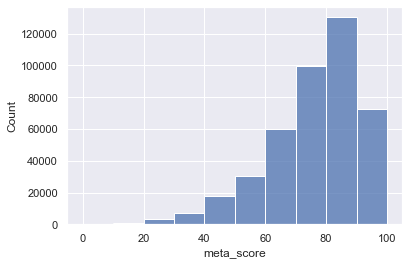

In [19]:
sns.histplot(df, legend=False, x='meta_score', bins=10)

Here we can see a highly skewed distribution. Majority of the ratings are above 70, like I expected. We want to take these groupings into account when we determining if a product is up for recommendation or not by creating our own custom scale based on these values.

### 3.2 What is the distribution among critics?
In order to find correlations between games its important multiple critics review many different products of the same catalogue. Let’s see how well the distribution is among all the critics that have written reviews on the website.

In [20]:
# Max number in pie chart
threshold = 20

# Count the amount of reviews a critic has written
df_critic_review_dist = df['review_critic'].value_counts()

# Create a subset of the threshold amount
# And summarise all others into the 'others' catagory
df_critic_review_sub_dist = df_critic_review_dist[:threshold]
df_critic_review_sub_dist['others'] = df_critic_review_dist[threshold:].sum()

<AxesSubplot:>

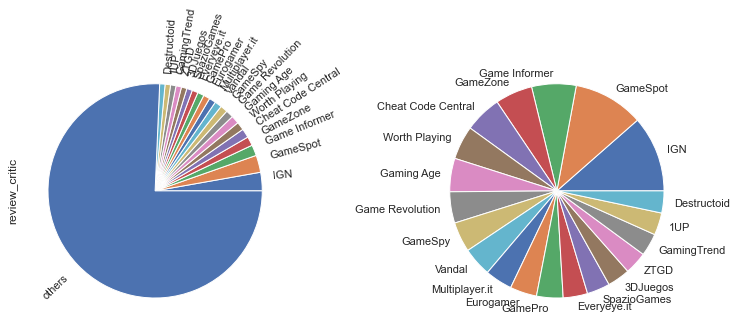

In [21]:
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
df_critic_review_sub_dist.plot.pie(rotatelabels=True)

plt.subplot(1, 2, 2)
df_critic_review_dist[:threshold].plot.pie(ylabel='', rotatelabels=False)

We can see that roughly 20 critics are responsible for about 25% of the reviews written on the website, with GameSpot and IGN being the big names on the website. I'm not completely satisfied with the visualization so let’s try at a different approach.

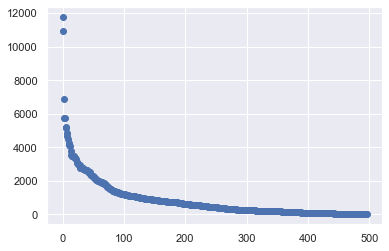

In [22]:
plt.scatter(df_critic_review_dist.reset_index(drop=True).index, df_critic_review_dist)
plt.show()

Here each dot represents a critic and the number of reviews they have posted is on the Y-axis. We can see that the two big contributors we mentioned before are responsible for roughly 22.000 reviews of the 400.000 reviews. After that we see a steady decline in the number of contributions made by the other critics. I'd say the pool of critics is still diverse enough.

### 3.3 Is there a bias to certain platforms/consoles?

<AxesSubplot:xlabel='platform', ylabel='meta_score'>

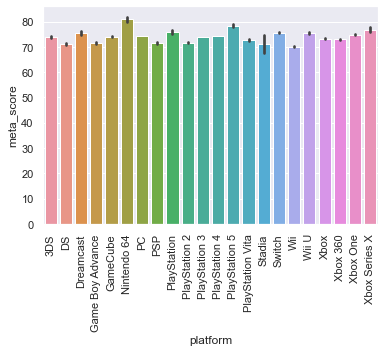

In [23]:
plt.xticks(rotation=90)
sns.barplot(data=df.sort_values(by='platform'), x='platform', y='meta_score')

Although the average score is pretty high overall, I can't necessarily say that there is any bias to a specific platform. We could expand on this visualization by creating a box plot for all platforms, to see if we are missing some details.

<AxesSubplot:xlabel='platform', ylabel='meta_score'>

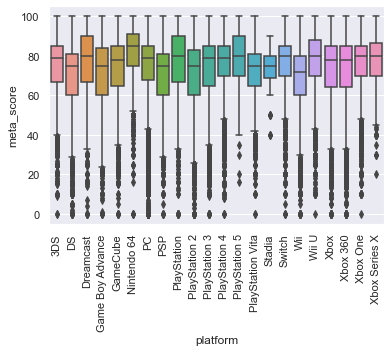

In [24]:
plt.xticks(rotation=90)
sns.boxplot(data=df.sort_values(by='platform'), x='platform', y='meta_score')

Once again, I'm not seeing any kind of bias to a specific platform (or company for that matter) which is good to see. Stadia is a bit of an outcast being the only platform that hasn't scored any 100 out of 100 games by any of the critics, but it's also relatively new in the scene.

### 3.4 Do reviewers restrict themselves to specific platforms?
If a publisher only writes reviews for their favorite platform, they probably have a bias in their reviews. We would preferably like to only take critics into consideration that are indifferent to the platform they are playing on.

<AxesSubplot:xlabel='review_critic', ylabel='Count'>

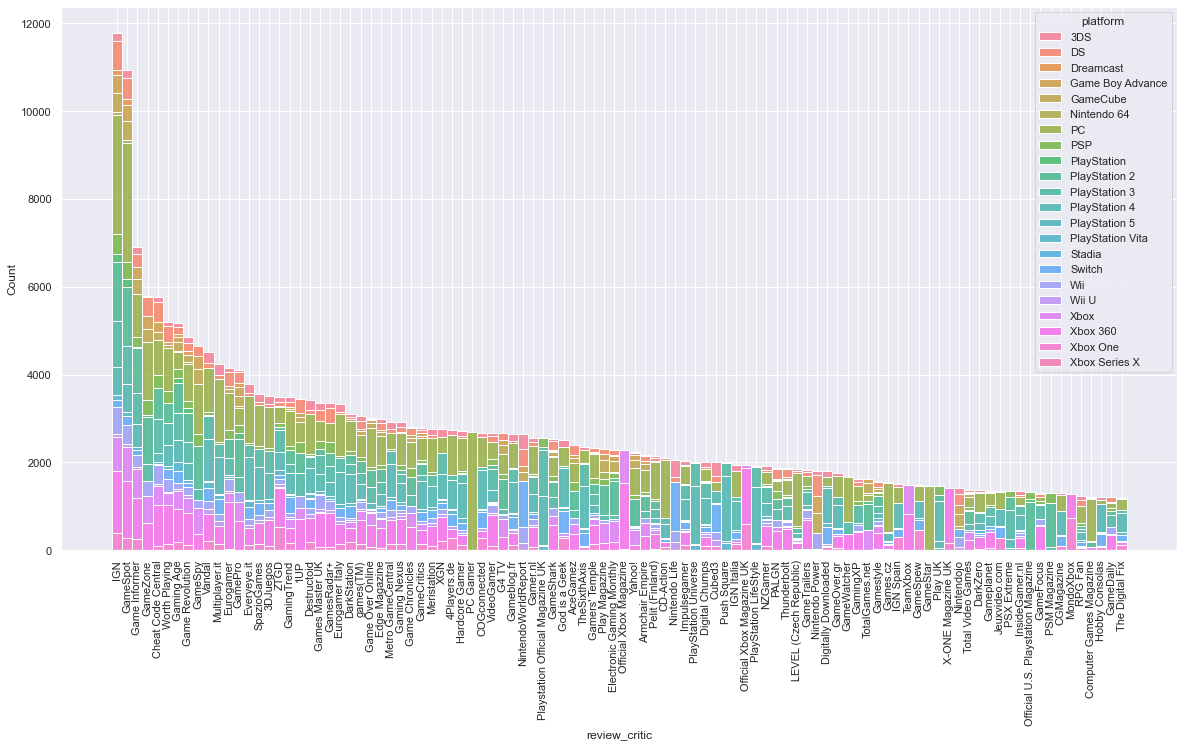

In [25]:
# Numbers of publishers to include in the 
# histogram, orderd from most reviews to least
number_of_publishers = 100

# Count the amount of reviews a critic has written
top_reviewers = df['review_critic'].value_counts().index
top_reviewers = top_reviewers[:number_of_publishers]

# Filter on the biggest publishers
df_publisher_reviews = df[df['review_critic'].isin(top_reviewers)].copy()

# Order by rank so we have the largest critics on the left of the graph
df_publisher_reviews['rank'] = pd.Categorical(df_publisher_reviews['review_critic'], top_reviewers)
df_publisher_reviews.sort_values(by=['rank', 'platform'], inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

sns.histplot(df_publisher_reviews, x='review_critic', hue='platform', multiple='stack', bins=number_of_publishers)

Although the distributions seem fine for the most part, it’s a bit obstructed by the number of colors that are splashed on the histogram. Another approach we can take is plotting the same graph but configuring the colors to represent the company that made the platform.

In [26]:
NINTENDO = [
    '3DS', 
    'DS', 
    'Game Boy Advance', 
    'GameCube', 
    'Nintendo 64', 
    'Switch', 
    'Wii', 
    'Wii U']

SONY = [
    'PSP', 
    'PlayStation', 
    'PlayStation 2', 
    'PlayStation 3', 
    'PlayStation 4', 
    'PlayStation 5', 
    'PlayStation Vita']

MICROSOFT = [
    'Xbox', 
    'Xbox360',
    'Xbox One', 
    'Xbox Series X']

In [27]:
df_publisher_reviews['company'] = 'Other'
df_publisher_reviews.loc[df_publisher_reviews['platform'].isin(MICROSOFT), 'company'] = 'Microsoft'
df_publisher_reviews.loc[df_publisher_reviews['platform'].isin(NINTENDO), 'company'] = 'Nintendo'
df_publisher_reviews.loc[df_publisher_reviews['platform'].isin(SONY), 'company'] = 'Sony'

<AxesSubplot:xlabel='review_critic', ylabel='Count'>

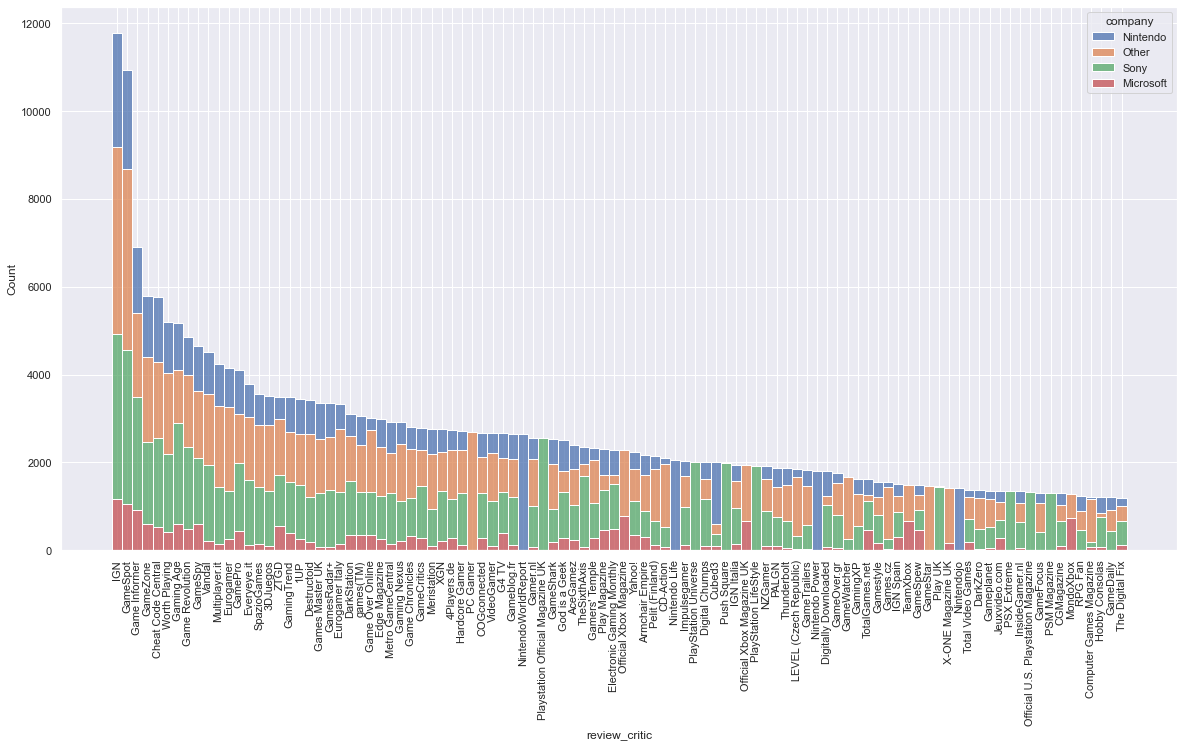

In [28]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

sns.histplot(df_publisher_reviews, x='review_critic', hue='company', multiple='stack', bins=number_of_publishers)

Now we can clearly see a few review critics that only review games for a specific company. We see a lot of Sony and Nintendo exclusive reviewers among the highest ranked critics. If we want our algorithm to be as unbiased as possible it might be a good idea discard these reviews, depending on if they still rate these games fairly or not.

## 4. Conclusion
First, we started of looking at the statistics of the dataset. We are talking about roughly 400.000 reviews of 10.000 games written by about 500 different critics. A game has on average 35 reviews with 7 being the lowest number of reviews for a game. 

After that, we've taken a look at the reason as to why we have so many null values in the dataset. The following explenations were given:

* Review content is not always provided; Metacritic states they re-evaluate yearly who is allowed to be a certified critic which means that we can keep these records in the dataset.
* Review dates up until 2010 are missing due to lack of data recording. The reviews themselves are still valid to be used.
* Meta scores are not always filled in by companies who don't agree with scoring system. These records will be removed due to the algorithm only performing well with numerical feedback

We've also removed a small number of duplicate reviews, most likely caused by a server/database communication error.

Next we've done some analysis on the data itself. Most notable results were the following:
* People tend to score games to the higher end of the spectrum, averaging at roughly a 75 out of 100. This is something we need to take into account when looking for recommendations.
* Roughly 20 review critics are responsible for 25% of the reviews on the website. The other 475 make up the rest of the reviews.
* The site does not promote games of a specific platform, with all platforms getting roughly the same score.
* There are quite a few critics that only review games of a specific company, which might introduce bias into the algorithm if their reviews are not evaluated properly.

I think this dataset can be very useful in searching for correlations between critics and products to generate good recommendations.